# Using the model to cluster songs according to their genre

In [90]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import torch
import deeplay as dl
import os
import deeptrack as dt

In [91]:
#Helper functions
def createGenreMap():
    genreMap = {} #key:track id, value:genre

    # Open the CSV file in read mode, NOTE: You have to have the file labels.csv in your directory, its available in drive
    with open('labels.csv', 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        #Skip first row (header row)
        next(csv_reader)
    
        # Iterate through the rows in the CSV file
        for row in csv_reader:
            raw_number = int(row[0])
            track_id = f"{raw_number:06d}"
            genre = row[1]
            genreMap[track_id] = genre

    return genreMap
    
def getLabel(genreMap, track_id):
    #Genre map is dictionary created above, track_id is string id of track.
    track_id_final = f"{track_id:06d}"
    return genreMap[track_id_final]

In [92]:
"""METHOD 1: UMAP"""

def umap_clustering(data, reduced_dim, genre_labels):
    """
    Parameters:
        data: All latent space representations of the tracks, shape (n_tracks, latent_dim)
        reduced_dim: Reduced dimension for UMAP (2 or 3)
        genre_labels: List of genre names corresponding to each track
    """
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    reducer = umap.UMAP(n_components=reduced_dim, min_dist=1)
    reduced_proj = reducer.fit_transform(data)

    colors = plt.cm.tab20(np.linspace(0, 1, 20))

    fig = plt.figure(figsize=(10, 7))

    if reduced_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_proj[:, 0], reduced_proj[:, 1], reduced_proj[:, 2],
                             c=numeric_labels, cmap='tab20')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    elif reduced_dim == 2:
        scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1],
                              c=numeric_labels, cmap='tab20', s=3)
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.ylim(6.5,13)
    else:
        print("Please enter 2 or 3 as the reduced_dim")
        return

    # Legend
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)
    cmap = plt.cm.tab20
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    patches = [mpatches.Patch(color=colors[i], label=name)
               for i, name in enumerate(genre_names)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
    plt.title("UMAP Clustering")
    plt.tight_layout()
    plt.show()

In [93]:
"""METHOD 2: PCA"""

def pca_clustering(data, reduced_dim, genre_labels):
    """
    Parameters:
        data: Latent representations of tracks, shape (n_tracks, latent_dim)
        reduced_dim: 2 or 3
        genre_labels: List of genre names (strings)
    """
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    # PCA transformation
    pca = PCA(n_components=reduced_dim)
    reduced_proj = pca.fit_transform(data)

    # Plot
    fig = plt.figure(figsize=(10, 7))

    if reduced_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_proj[:, 0], reduced_proj[:, 1], reduced_proj[:, 2],
                             c=numeric_labels, cmap='tab20', s=3)
        ax.set_xlabel("1st principal direction")
        ax.set_ylabel("2nd principal direction")
        ax.set_zlabel("3rd principal direction")
    elif reduced_dim ==2:
        scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1],
                              c=numeric_labels, cmap='tab20')
        plt.xlabel("1st principal direction")
        plt.ylabel("2nd principal direction")
        plt.xlim(0,500)
        plt.ylim(-500,500)
    else:
        print('Please make the reduced_dim 2 or 3')
        return

    # Legend with genre names
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)

    cmap = plt.cm.tab20
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    patches = [mpatches.Patch(color=colors[i], label=name)
               for i, name in enumerate(genre_names)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
    plt.title("PCA Clustering")
    plt.tight_layout()
    plt.show()

In [94]:
mapping = createGenreMap()

In [95]:
#Get data
track_ids = mapping.keys()
print(f"Track names: {list(track_ids)}")

genre_labels = list(mapping.values())
print(f"Genre corresponding to each track: {genre_labels}")

number_of_tracks = len(track_ids)
genres = set(genre_labels)
num_of_genres = len(genres)

print(f"Number of tracks: {number_of_tracks}")
print(f"Genres: {genres}")
print(f"Number of genres: {num_of_genres}")

Track names: ['000002', '000003', '000005', '000010', '000020', '000026', '000030', '000046', '000048', '000134', '000135', '000136', '000137', '000138', '000139', '000140', '000141', '000142', '000144', '000145', '000146', '000147', '000148', '000149', '000150', '000151', '000152', '000153', '000154', '000155', '000156', '000157', '000158', '000159', '000160', '000161', '000162', '000163', '000164', '000165', '000166', '000167', '000168', '000169', '000170', '000171', '000172', '000173', '000174', '000175', '000176', '000177', '000178', '000179', '000181', '000182', '000183', '000184', '000185', '000188', '000189', '000190', '000191', '000192', '000193', '000194', '000195', '000196', '000197', '000198', '000199', '000200', '000201', '000202', '000203', '000204', '000205', '000206', '000207', '000208', '000209', '000210', '000211', '000212', '000213', '000226', '000228', '000236', '000237', '000238', '000246', '000247', '000248', '000249', '000250', '000251', '000252', '000253', '00025

In [96]:
"""
#Example usage of umap
latent_dim = 20
reduced_dim = 3
dummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track

umap_clustering(dummy_data, reduced_dim, genre_labels)
"""

'\n#Example usage of umap\nlatent_dim = 20\nreduced_dim = 3\ndummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track\n\numap_clustering(dummy_data, reduced_dim, genre_labels)\n'

In [97]:
#Example usage of pca
"""
latent_dim = 20
reduced_dim = 2
dummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track

pca_clustering(dummy_data, reduced_dim, genre_labels)
"""

'\nlatent_dim = 20\nreduced_dim = 2\ndummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track\n\npca_clustering(dummy_data, reduced_dim, genre_labels)\n'

In [98]:
#Try the vae model


vae = dl.VariationalAutoEncoder(input_size=(512,512),
    latent_dim=50, channels=[32, 64, 128],
    reconstruction_loss=torch.nn.MSELoss()
).create()
vae.load_state_dict(torch.load("vaeLowDKL.pth"))
vae.eval()



wae = dl.WassersteinAutoEncoder(input_size=[512,512],
    channels=[16, 32, 64, 128, 256], latent_dim=128,
    reconstruction_loss=torch.nn.MSELoss(reduction="mean"), optimizer=dl.AdamW(lr=1e-4)
).create()
wae.load_state_dict(torch.load("wae.pth"))
wae.decoder.blocks[4].activation = torch.nn.Identity()
wae.eval()

use_wae = True

In [99]:
#Preprocess data
data_dir = os.path.expanduser("./trainImages")

# Load image files using ImageFolder
trainFiles = dt.sources.ImageFolder(root=data_dir)
print(f"Number of train images: {len(trainFiles)}")

Number of train images: 124879


In [100]:
#Create image pipeline
class CropWidth:
    def __init__(self, target_width):
        self.target_width = target_width

    def __call__(self, x: torch.Tensor):
        # assuming input shape [C, H, W]
        return x[..., :self.target_width]
    
image_pip = (dt.LoadImage(trainFiles.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float) >> CropWidth(512))

In [101]:
#creating a test dataset, it is the same dataset, but added the genre as label as well
from dataset import Dataset
label_pip = dt.Value(trainFiles.label_name[:6]) >> int
test_dataset = Dataset(image_pip & label_pip, inputs=trainFiles)
test_loader = dl.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [102]:
mu_list, labels = [], []
if use_wae:
    model = wae
else:
    model = vae
i = 0
with torch.no_grad():
    for img, raw_track_id in test_loader:
        if i%1000 == 0:
            print (i)
        track_id = int(raw_track_id[0])
        label = getLabel(mapping, track_id)
        mu = model.encode(img)
        mu = mu.detach()
        labels.append(label)
        mu_list.append(mu)
        i+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000


In [103]:
mu_array = torch.cat(mu_list, dim=0).detach().numpy()

In [104]:
print(len(labels))
print(mu_array.shape)

124879
(124879, 128)


/home/rasmus/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


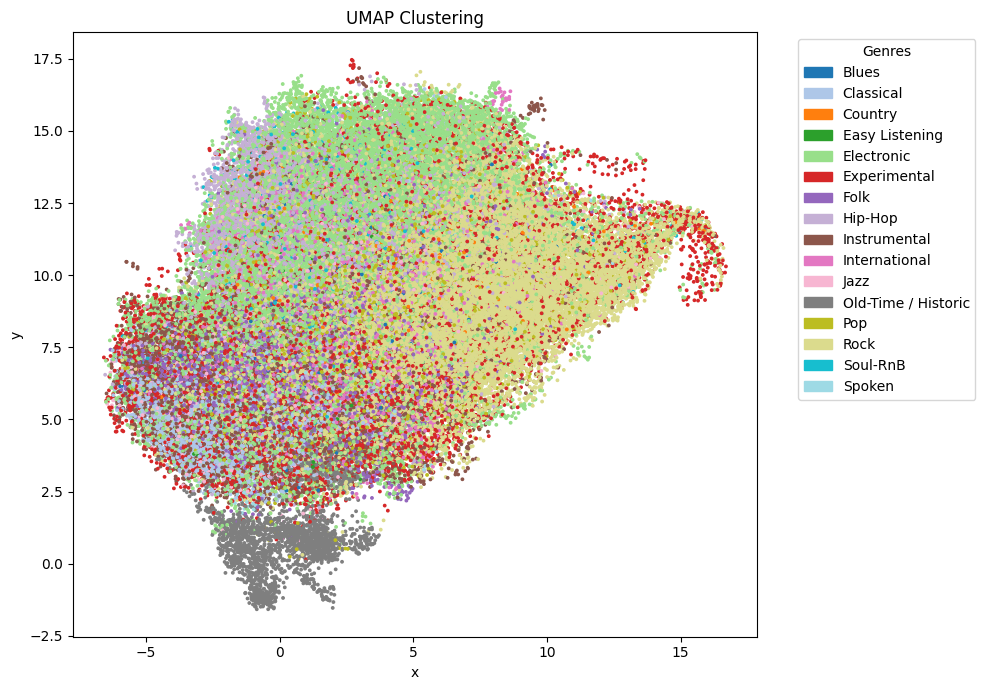

In [105]:
reduced_dim = 2
data = mu_array
genre_labels = labels
#pca_clustering(data, reduced_dim, genre_labels)
umap_clustering(data, reduced_dim, genre_labels)